# Skoltech: Experimental Data Processing - Final Project

**Course:** "Experimental data processing"
**Term:** 1B, October 2025
**Project:** Catching a target using RADAR data with the Extended Kalman filter.

### Objective

The goal of this project is to implement an Extended Kalman Filter (EKF) to track two airplanes based on noisy RADAR measurements. Airplane B is attempting to catch up to Airplane A. We need to estimate their trajectories, filter out the noise, and determine the minimum distance between them and the time at which this occurs.

## Data Loading

The RADAR measurements for the two airplanes are provided in `z1_RADAR.txt` and `z2_RADAR.txt`.

Each file contains three rows:
1. **Range (D)** in meters.
2. **Azimuth (β)** in radians.
3. **Elevation (ε)** in radians.

We will define functions to load this data and convert the polar coordinates (D, β, ε) into Cartesian coordinates (x, y, z).

The transformation is as follows:
- `x = D * cos(ε) * cos(β)`
- `y = D * cos(ε) * sin(β)`
- `z = D * sin(ε)`

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def load_data(filename):
    data = np.loadtxt(filename)
    return data[1:, 0], data[1:, 1], data[1:, 2]

def polar_to_cartesian(d, beta, epsilon):
    x = d * np.cos(epsilon) * np.cos(beta)
    y = d * np.cos(epsilon) * np.sin(beta)
    z = d * np.sin(epsilon)
    return x, y, z

file_path_a = 'data/z1_RADAR.txt'
d_a, beta_a, eps_a = load_data(file_path_a)
x_a_nf, y_a_nf, z_a_nf = polar_to_cartesian(d_a, beta_a, eps_a)

file_path_b = 'data/z2_RADAR.txt'
d_b, beta_b, eps_b = load_data(file_path_b)
x_b_nf, y_b_nf, z_b_nf = polar_to_cartesian(d_b, beta_b, eps_b)

## Extended Kalman Filter (EKF) Implementation

Define the components of EKF.

### State and Models

**State Vector (`X`):** The state of each airplane is defined by its position and velocity in 3D Cartesian space.  
`X = [x, v_x, y, v_y, z]`

**Observation Model (`h(X)`):** This non-linear function maps the Cartesian state vector back to the RADAR's polar measurements.  
`h(X) = [D, β, ε]`

In [2]:
def h(state):
    x, _, y, _, z = state.flatten()
    d_sq = x**2 + y**2 + z**2
    d = np.sqrt(d_sq)
    beta = np.arctan2(y, x)
    epsilon = np.arcsin(z / d)
    return np.array([d, beta, epsilon]).reshape(3, 1)

def H_jacobian(state):
    x, _, y, _, z = state.flatten()
    
    H = np.zeros((3, 5))
    
    d_sq = x**2 + y**2 + z**2
    d = np.sqrt(d_sq)
    xy_sq = x**2 + y**2
    
    H[0, 0] = x / d
    H[0, 2] = y / d
    H[0, 4] = z / d
    
    H[1, 0] = -y / xy_sq
    H[1, 2] = x / xy_sq

    H[2, 0] = -x * z / (d_sq * np.sqrt(xy_sq))
    H[2, 2] = -y * z / (d_sq * np.sqrt(xy_sq))
    H[2, 4] = np.sqrt(xy_sq) / d_sq

    return H

### EKF Algorithm

Now we'll create the main EKF function. It will iterate through the measurements and perform the two main steps:
1.  **Prediction:** Project the state and covariance ahead in time.
2.  **Update:** Correct the prediction using the current measurement.

In [3]:
T = 1.0

Phi = np.array([
    [1, T, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 1, T, 0],
    [0, 0, 0, 1, 0],
    [0, 0, 0, 0, 1]
])

In [4]:
def run_ekf(measurements_d, measurements_beta, measurements_eps, Q, R, P0, X0):
    num_steps = len(measurements_d)
    
    X_hist = np.zeros((5, num_steps))
    P_hist = np.zeros((5, 5, num_steps))
    
    X_i = X0.copy()
    P_i = P0.copy()
    
    I = np.eye(5)
    
    for i in range(num_steps):
        X_pred = Phi @ X_i
        P_pred = Phi @ P_i @ Phi.T + Q
        
        Z_i = np.array([measurements_d[i], measurements_beta[i], measurements_eps[i]]).reshape(3, 1)
        
        if np.isnan(Z_i).any():
            X_i = X_pred
            P_i = P_pred
        else:
            H_i = H_jacobian(X_pred)
            
            Y_i = Z_i - h(X_pred)
            Y_i[1] = (Y_i[1] + np.pi) % (2 * np.pi) - np.pi
            
            S_i = H_i @ P_pred @ H_i.T + R
            
            K_i = P_pred @ H_i.T @ np.linalg.inv(S_i)
            
            X_i = X_pred + K_i @ Y_i
            P_i = (I - K_i @ H_i) @ P_pred
        
        X_hist[:, i] = X_i.flatten()
        P_hist[:, :, i] = P_i
        
    return X_hist, P_hist

## 4. Model Configuration and Execution

We now set up the specific parameters for the EKF as defined in the assignment for both airplanes. This step will only run if the data files were loaded successfully.

In [5]:
T = 1.0

P0 = np.diag([1e5, 1e5, 1e5, 1e5, 1e5])

x0_a, y0_a, z0_a = polar_to_cartesian(d_a[0], beta_a[0], eps_a[0])
X0_a = np.array([x0_a, 0, y0_a, 0, z0_a]).reshape(5, 1)

x0_b, y0_b, z0_b = polar_to_cartesian(d_b[0], beta_b[0], eps_b[0])
X0_b = np.array([x0_b, 0, y0_b, 0, z0_b]).reshape(5, 1)

sigma_d_sq = 200**2
sigma_beta_sq = 0.01**2
sigma_eps_sq = 0.01**2
R = np.diag([sigma_d_sq, sigma_beta_sq, sigma_eps_sq])

G = np.array([
    [T**2/2, 0, 0],
    [T,       0, 0],
    [0, T**2/2, 0],
    [0, T,       0],
    [0, 0,       T]
]) 

sigma_ax_a_sq = 0.02
sigma_ay_a_sq = 0.02
sigma_az_a_sq = 1.0
Q_a_vars = np.diag([sigma_ax_a_sq, sigma_ay_a_sq, sigma_az_a_sq])
Q_a = G @ Q_a_vars @ G.T
X_hist_a, P_hist_a = run_ekf(d_a, beta_a, eps_a, Q_a, R, P0, X0_a)

sigma_ax_b_sq = 0.01
sigma_ay_b_sq = 0.01
sigma_az_b_sq = 1.0
Q_b_vars = np.diag([sigma_ax_b_sq, sigma_ay_b_sq, sigma_az_b_sq])
Q_b = G @ Q_b_vars @ G.T
X_hist_b, P_hist_b = run_ekf(d_b, beta_b, eps_b, Q_b, R, P0, X0_b)

## 5. Analysis of Results

Now we analyze the output of the filters. Our primary goal is to determine the minimum distance between the two airplanes.

We will perform the following steps:
1.  Calculate the distance at each time step using the raw, non-filtered Cartesian coordinates.
2.  Calculate the distance at each time step using the filtered state vectors from the EKF.
3.  Plot both distances over time to compare them.
4.  Identify the minimum filtered distance and the time it occurs.

Minimum Filtered Distance: 5787.60 meters
Time of Minimum Distance: 1184 seconds


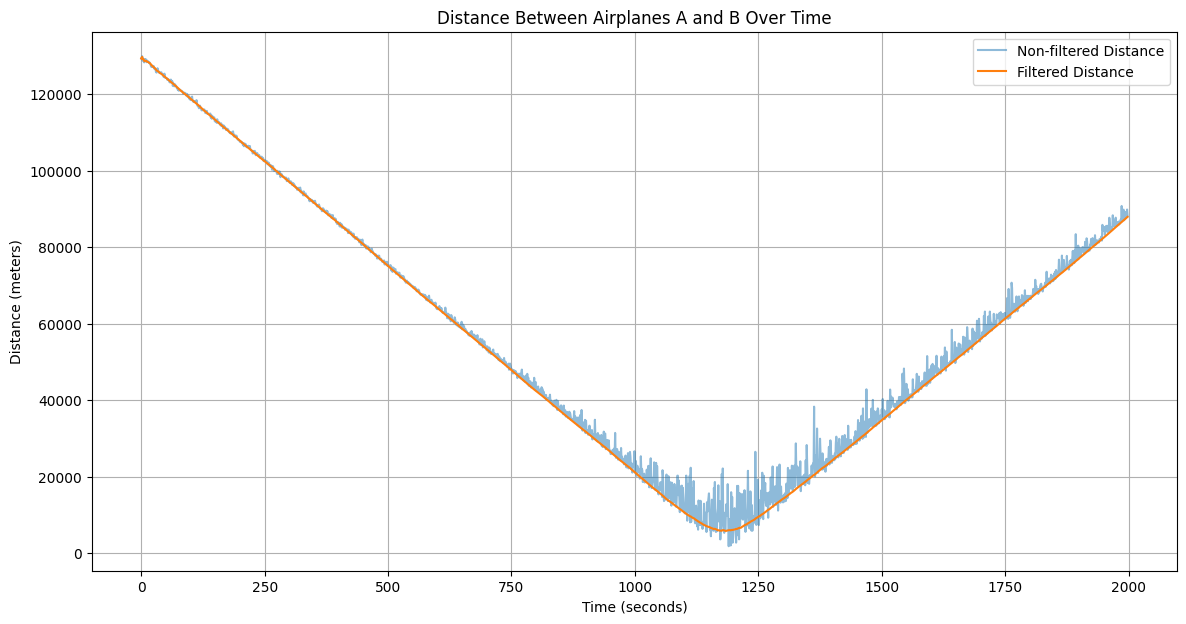

In [6]:
dist_nf = np.sqrt((x_a_nf - x_b_nf)**2 + (y_a_nf - y_b_nf)**2 + (z_a_nf - z_b_nf)**2)

x_a_f = X_hist_a[0, :]
y_a_f = X_hist_a[2, :]
z_a_f = X_hist_a[4, :]

x_b_f = X_hist_b[0, :]
y_b_f = X_hist_b[2, :]
z_b_f = X_hist_b[4, :]

dist_f = np.sqrt((x_a_f - x_b_f)**2 + (y_a_f - y_b_f)**2 + (z_a_f - z_b_f)**2)

min_dist_f = np.min(dist_f)
time_of_min_dist = np.argmin(dist_f) * T

print(f"Minimum Filtered Distance: {min_dist_f:.2f} meters")
print(f"Time of Minimum Distance: {time_of_min_dist:.0f} seconds")

time_axis = np.arange(len(dist_f)) * T

plt.figure(figsize=(14, 7))
plt.plot(time_axis, dist_nf, alpha=0.5, label='Non-filtered Distance')
plt.plot(time_axis, dist_f, label='Filtered Distance')
plt.title('Distance Between Airplanes A and B Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Distance (meters)')
plt.legend()
plt.grid(True)
plt.show()

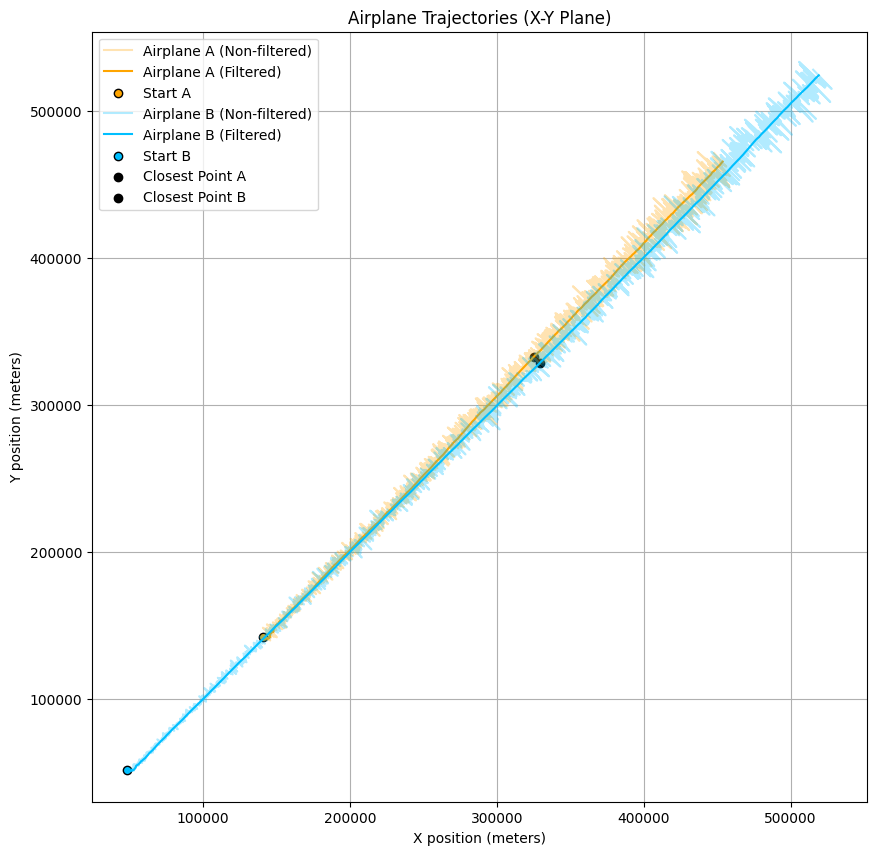

In [7]:
plt.figure(figsize=(10, 10))
plt.plot(x_a_nf, y_a_nf, c='orange', alpha=0.3, label='Airplane A (Non-filtered)')
plt.plot(x_a_f, y_a_f, c='orange', label='Airplane A (Filtered)')
plt.scatter(x_a_f[0], y_a_f[0], marker='o', c='orange', edgecolors='black', label='Start A')

plt.plot(x_b_nf, y_b_nf, alpha=0.3, c='deepskyblue', label='Airplane B (Non-filtered)')
plt.plot(x_b_f, y_b_f, c='deepskyblue', label='Airplane B (Filtered)')

plt.scatter(x_b_f[0], y_b_f[0], marker='o', c='deepskyblue', edgecolors='black', label='Start B')

idx_min = int(time_of_min_dist / T)
plt.scatter(x_a_f[idx_min], y_a_f[idx_min], marker='o', c='black', label='Closest Point A')
plt.scatter(x_b_f[idx_min], y_b_f[idx_min], marker='o', c='black', label='Closest Point B')

plt.title('Airplane Trajectories (X-Y Plane)')
plt.xlabel('X position (meters)')
plt.ylabel('Y position (meters)')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

In [ ]:
import matplotlib.animation as animation

x_a_f, y_a_f = X_hist_a[0, :], X_hist_a[2, :]
x_b_f, y_b_f = X_hist_b[0, :], X_hist_b[2, :]
x_a_nf, y_a_nf = x_a_nf, y_a_nf
x_b_nf, y_b_nf = x_b_nf, y_b_nf

min_length = min(len(x_a_f), len(x_b_f), len(x_a_nf), len(x_b_nf))
num_frames = min_length

x_a_f, y_a_f = x_a_f[:num_frames], y_a_f[:num_frames]
x_b_f, y_b_f = x_b_f[:num_frames], y_b_f[:num_frames]
x_a_nf, y_a_nf = x_a_nf[:num_frames], y_a_nf[:num_frames]
x_b_nf, y_b_nf = x_b_nf[:num_frames], y_b_nf[:num_frames]

fig, ax = plt.subplots(figsize=(10, 10))
all_x = np.concatenate([x_a_nf, x_b_nf])
all_y = np.concatenate([y_a_nf, y_b_nf])
margin = 2000
ax.set_xlim(np.nanmin(all_x) - margin, np.nanmax(all_x) + margin)
ax.set_ylim(np.nanmin(all_y) - margin, np.nanmax(all_y) + margin)
ax.set_title('Airplane Trajectory Animation (X-Y Plane)')
ax.set_xlabel('X Position (meters)')
ax.set_ylabel('Y Position (meters)')
ax.set_aspect('equal')
ax.grid(True)

trail_a, = ax.plot([], [], c='orange', label='Airplane A Trail')
trail_b, = ax.plot([], [], c='deepskyblue', label='Airplane B Trail')
raw_scatter_a, = ax.plot([], [], c='orange', alpha=0.5, label='Raw Measurement A')
raw_scatter_b, = ax.plot([], [], c='deepskyblue', alpha=0.5, label='Raw Measurement B')
head_a = ax.scatter([], [], c='orange', label='Airplane A')
head_b = ax.scatter([], [], c='deepskyblue', label='Airplane B')
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=12,
                    bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))
ax.legend(loc='upper right')

def init():
    trail_a.set_data([], [])
    trail_b.set_data([], [])
    raw_scatter_a.set_data([], [])
    raw_scatter_b.set_data([], [])
    head_a.set_offsets(np.empty((0, 2)))
    head_b.set_offsets(np.empty((0, 2)))
    time_text.set_text('')
    return []

def update(frame):
    trail_a.set_data(x_a_f[:frame+1], y_a_f[:frame+1])
    trail_b.set_data(x_b_f[:frame+1], y_b_f[:frame+1])
    raw_scatter_a.set_data([x_a_nf[:frame+1], y_a_nf[:frame+1]])
    raw_scatter_b.set_data([x_b_nf[:frame+1], y_b_nf[:frame+1]])
    head_a.set_offsets([x_a_f[frame], y_a_f[frame]])
    head_b.set_offsets([x_b_f[frame], y_b_f[frame]])
    time_text.set_text(f'Time: {frame} s')
    return []

frames_to_render = np.arange(0, num_frames, 3)
anim = animation.FuncAnimation(fig, update, frames=frames_to_render,
                                init_func=init, interval=20)

gif_filename = 'airplane_trajectories.gif'
writer = animation.PillowWriter(fps=50, bitrate=1800)
anim.save(gif_filename, writer=writer)

plt.close(fig)

## 6. Discussion and Conclusion